# MLP
Based on [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Read in the names
names = open('names.txt', 'r').read().splitlines()

In [169]:
# BUild the vocabulary and mappings
characters = sorted(list(set("".join(names))))
str_to_int = {string:integer+1 for integer, string in enumerate(characters)}
str_to_int['.'] = 0
int_to_str = {integer:string for string, integer in str_to_int.items()}

In [170]:
block_size = 3  # Context size - number of characters used to predict the next one

In [171]:
X = []  # inputs/context
Y = []  # targets

for name in names:
    context = [0] * block_size      
    for character in name + ".":
        ix = str_to_int[character]  # Grab index of that character
        X.append(context)           
        Y.append(ix)
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

# Simple forward pass
[This blogpost](http://blog.ezyang.com/2019/05/pytorch-internals/) about Pytorch internals is very helpful in understanding what happens under the hood in pytorch when we use, for instance, something like `.view()`.

In [172]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)  # embedding

W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]  # All parameters of our network
print("Total parameters: ", sum(p.nelement() for p in parameters))

Total parameters:  3481


In [173]:
# Allow gradients
for p in parameters:
    p.requires_grad = True

In [174]:
# Increasing learning rate
n_steps = 10000
# lr_exp = torch.linspace(-3.0, 0.0, n_steps)
# lrs = 10**lr_exp

In [175]:
lri = []
lossi = []

# Forward pass
for i in range(n_steps):
    # Minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # Embedding
    emb = C[X[ix]]

    # First layer
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

    # Second layer
    logits = h @ W2 + b2

    # Cross entropy (softmax + avg negative log likelihood)
    loss = F.cross_entropy(logits, Y[ix])
    
    # Zero gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Gradient desceint
    lr = 0.01 #lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # Storage
    # lri.append(lr_exp[i])
    # lossi.append(loss.item())

print("Loss: ", loss.item())

Loss:  2.889554262161255


In [176]:
# Embedding
emb = C[X]

# First layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

# Second layer
logits = h @ W2 + b2

# Cross entropy (softmax + avg negative log likelihood)
loss = F.cross_entropy(logits, Y)

print("Loss: ", loss.item())

Loss:  2.5704538822174072


# Train, Test, Split

In [177]:
def build_dataset(names):
    block_size = 3
    X, Y = [], []
    for name in names:
        context = [0] * block_size
        for character in name + ".":
            ix = str_to_int[character]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [178]:
import random

random.seed(42)
random.shuffle(names)

n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [179]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)  # embedding

W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]  # All parameters of our network
print("Total parameters: ", sum(p.nelement() for p in parameters))

Total parameters:  3481


Train using `Xtr` and `Ytr`

In [180]:
# Allow gradients
for p in parameters:
    p.requires_grad = True

In [181]:
n_steps = 30000

In [182]:
lri = []
lossi = []

# Forward pass
for i in range(n_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Embedding
    emb = C[Xtr[ix]]

    # First layer
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

    # Second layer
    logits = h @ W2 + b2

    # Cross entropy (softmax + avg negative log likelihood)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Zero gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Gradient desceint
    lr = 0.01 #lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

print("Loss: ", loss.item())

Loss:  2.583037853240967


Evaluate loss on `Xdev` and `Ydev`

In [183]:
# Embedding
emb = C[Xdev]

# First layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

# Second layer
logits = h @ W2 + b2

# Cross entropy (softmax + avg negative log likelihood)
loss = F.cross_entropy(logits, Ydev)

print("Loss: ", loss.item())

Loss:  2.4926576614379883


Currently it is underfitting because training and test loss are about the same.

# Increase size of network

In [188]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g)  # embedding

W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)

W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]  # All parameters of our network
print("Total parameters: ", sum(p.nelement() for p in parameters))

Total parameters:  10281


In [189]:
# Allow gradients
for p in parameters:
    p.requires_grad = True

In [194]:
n_steps = 30000

In [197]:
lri = []
lossi = []
stepi = []

# Forward pass
for i in range(n_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Embedding
    emb = C[Xtr[ix]]

    # First layer
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

    # Second layer
    logits = h @ W2 + b2

    # Cross entropy (softmax + avg negative log likelihood)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Zero gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Gradient desceint
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.item())

print("Loss: ", loss.item())

Loss:  2.2292640209198


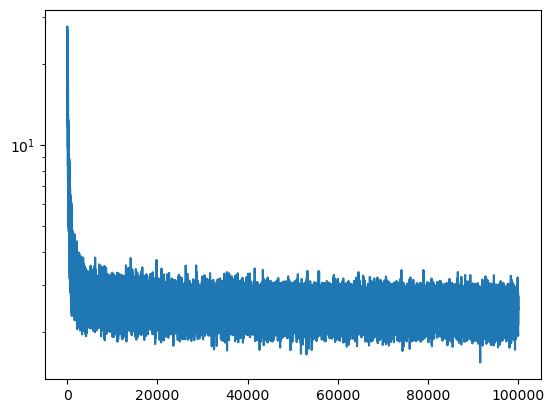

In [192]:
plt.plot(stepi, lossi)
plt.yscale('log')

# Visualize the 2D embeddings learned by the neural net

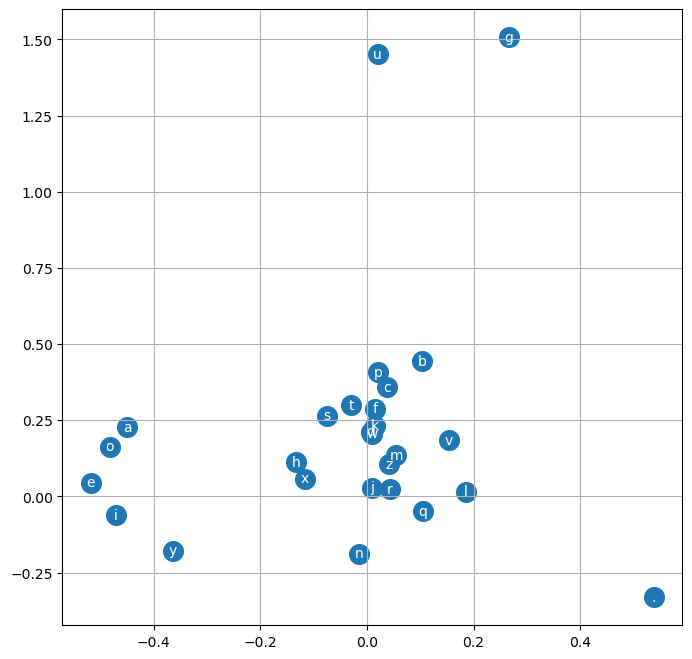

In [198]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), int_to_str[i], ha='center', va='center', color='white')
plt.grid('minor')

# Larger Embedding Dimension

In [208]:
g = torch.Generator().manual_seed(2147483647)

emb_dim = 10

C = torch.randn((27, emb_dim), generator=g)  # embedding

W1 = torch.randn((3*emb_dim, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]  # All parameters of our network
print("Total parameters: ", sum(p.nelement() for p in parameters))

Total parameters:  11897


In [209]:
# Allow gradients
for p in parameters:
    p.requires_grad = True

n_steps = 50000

In [210]:
lri = []
lossi = []
stepi = []

In [213]:
# Forward pass
for i in range(n_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Embedding
    emb = C[Xtr[ix]]

    # First layer
    h = torch.tanh(emb.view(-1, emb_dim*3) @ W1 + b1)

    # Second layer
    logits = h @ W2 + b2

    # Cross entropy (softmax + avg negative log likelihood)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Zero gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Gradient desceint
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

print("Loss: ", loss.item())

Loss:  1.701916217803955


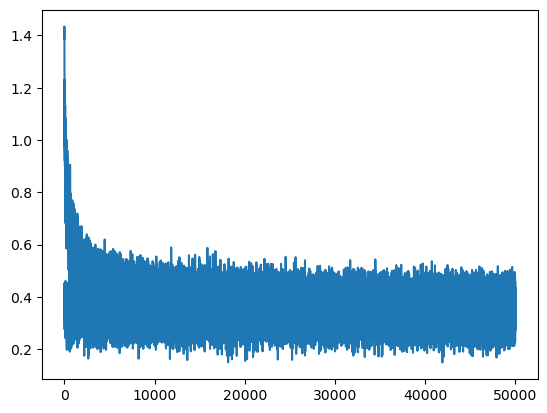

In [214]:
plt.plot(stepi, lossi)

# Sampling from the model

In [222]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size   # initialize with all dots
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(int_to_str[i] for i in out))

carmah.
amille.
khirmani.
thol.
skandan.
jazonel.
delyah.
jareei.
nermara.
chaiir.
kaleig.
dham.
jore.
quinn.
shoilea.
jambi.
wajero.
dearyni.
jaxeelinsley.
dae.
